In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import learn_utils
import meta_features as mf
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import butter, lfilter, filtfilt
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter


import scipy.signal as signal
import matplotlib.pyplot as plt

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Loading files names

In [2]:
def loadFile(file_name, verbose=False):
    ##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
    # THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    #print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(csv_dir, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    #print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows

In [3]:
csv_dir = "../data/annotated_csv/"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

In [4]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [243]:
def plotAcc(data, suptitle="Accelerometer signal", feature= 'High_level', plt_win_func=False):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
                # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
                norm_dataX = data["x"][count]
                norm_dataY = data["y"][count]
                norm_dataZ = data["z"][count]
                
                #window_fuction = np.sin(np.linspace(0, np.pi, 5))**2
                
                #slide_len = 1
                #segment_len = 5
                
                #energyx = []
                #energyy = []
                #energyz = []
                #for start_pos in range(0, len(norm_dataX), slide_len):
                #    end_pos = start_pos + segment_len
                #    # make a copy so changes to 'segments' doesn't modify the original data
                #    x_segment = np.copy(norm_dataX[start_pos:end_pos])
                #    y_segment = np.copy(norm_dataY[start_pos:end_pos])
                #    z_segment = np.copy(norm_dataZ[start_pos:end_pos])
                #    # if we're at the end and we've got a truncated segment, drop it
                #    if len(x_segment) != segment_len:
                #        continue
                #    energyx.append(mf.fft_energy(x_segment) * window_fuction)#np.hanning(len(x_segment))))
                #    energyy.append(mf.fft_energy(y_segment) * window_fuction)#np.hanning(len(y_segment))))
                #    energyz.append(mf.fft_energy(z_segment) * window_fuction)#np.hanning(len(z_segment))))
                
                #norm_dataX *= np.hanning(len(norm_dataX))
                #norm_dataY *= np.hanning(len(norm_dataY))
                #norm_dataZ *= np.hanning(len(norm_dataZ))
                
                row[j].set_title("W={}. {}={} ".format(count, feature, data['l'][count][0]), fontsize=8, fontweight="bold")
                row[j].set_ylabel('g\'s (9.8 m/s^2)')
                #row[j].set_ylim((-1,1))
                row[j].set_xlim((0,len(norm_dataX)))
                row[j].plot(norm_dataX, label="x")
                row[j].plot(norm_dataY, label="y")
                row[j].plot(norm_dataZ, label="z")
                # draw a default vline at x=1 that spans the yrange
                row[j].axvline(x=len(norm_dataX)/2, color='m', marker='.')
                row[j].grid()
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
    
    fig.suptitle('{} for {}'.format(suptitle, data['file'][0]), fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace= 0.5)
    plt.draw()

In [244]:
def preprocess(data, Fs):
    ##### COMPUTING THE AC COMPONENT  (Transformation I: Offset Translation) ####
    data_AC = np.array(data) - np.mean(data)
    ####
    
    #### Transformation II: Amplitude Scaling ####
    data_Scaled = (data_AC) / np.std(data_AC)
    
    ##### SMOOTH USING BUTTERWORTH FILTER #####
    # Butterworth filter properties
    # Correct the cutoff frequency for the number of passes in the filter
    C = 0.802
    freq = Fs   # Calculating frequency
    b, a = butter(3, (5/C)/(freq/2), btype = 'low') # BF order 3
    # applying butterworth filter for x axis, filter with phase shift correction
    data_filtered = filtfilt(b, a, data_Scaled)
    ####
    
    return data_filtered

In [245]:
#from __future__ import print_function
#Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print '\r{} |{}| {}% {}'.format(prefix, bar, percent, suffix)
    print '\r'
    # Print New Line on Complete
    if iteration == total: 
        print()

In [248]:
##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
# THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)
from IPython.display import clear_output
failed_files = []
frequences = []

dataset = []
# CONDUCTING TEST JUST ON ONE FILE
n_files = len(files)
printProgressBar(0, n_files, prefix = 'Progress:', suffix = 'Complete', length = 50)
for f_ind, f in enumerate(files):
    csv_filename = f
    file_data = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    #print 'Processing: "{}"'.format(csv_filename)

    # load the data, abort in case of error.
    try:
        file_data = loadFile(csv_filename)
    except ValueError as e:
        #print traceback.format_exc()
        failed_files.append(csv_filename)
        continue

    #### Normalize to g's accelerometer axis ####
    w_accX = []
    w_accY = []
    w_accZ = []
    w_feat = []
    time_interval = file_data[-1]['time'].iloc[-1]
    nsamps = 0
    #print '-- Normalizing accelerometer data...'
    # Initial call to print 0% progress
    for i, w in enumerate(file_data):
        
        #print len(w['accX']) - len(w['accX'].dropna()) 
        w_labels = w.loc[w['accX'].dropna().index.tolist()]['high_level'].tolist()
        tempX = []
        tempY = []
        tempZ = []
        tempFeat = []
        
        if i > 0:
            values = list(set(w['time']) - set(file_data[i-1]['time']))
            result = w[w['time'].isin(values)]
            nsamps += len(result['accX'].dropna().as_matrix())
        else:
            nsamps += len(w['accX'].dropna().as_matrix())
        
        for ind,(x,y,z) in enumerate(zip(w['accX'].dropna().as_matrix(),
                                         w['accY'].dropna().as_matrix(),
                                         w['accZ'].dropna().as_matrix())):
            tempX.append(x/16384.0)
            tempY.append(y/16384.0)
            tempZ.append(z/16384.0)
            tempFeat.append(w_labels[ind])
        w_accX.append(tempX)
        w_accY.append(tempY)
        w_accZ.append(tempZ)
        w_feat.append(tempFeat)
    
    Fs = nsamps/time_interval
    proccAccX = []
    proccAccY = []
    proccAccZ = []
    for l in range(len(w_accX)):
        proccAccX.append(preprocess(w_accX[l],Fs) * np.hanning(len(w_accX[l])))
        proccAccY.append(preprocess(w_accY[l],Fs) * np.hanning(len(w_accY[l])))
        proccAccZ.append(preprocess(w_accZ[l],Fs) * np.hanning(len(w_accZ[l])))
    
    dic = {'x'   : proccAccX,
           'y'   : proccAccY,
           'z'   : proccAccZ,
           'l'   : w_feat,
           'duration' : time_interval, 
           'file': csv_filename} 
    df = pd.DataFrame(dic, columns=['x','y','z','l','file'])
    dataset.append(df)
    #clear_output()
    frequences.append(Fs)
    printProgressBar(f_ind, n_files, prefix = 'Progress:', suffix = 'Complete | Fs:{:.2f} | AvgFs: {:.2f}'.format(Fs,np.mean(frequences)), length = 50)
    
print('DONE!')
#print 'Files average frequency of {} with std. deviation of {}'.format(np.mean(frequences),np.std(frequences))

Progress: |--------------------------------------------------| 0.0% Complete

Progress: |--------------------------------------------------| 0.0% Complete | Fs:48.95 | AvgFs: 48.95

Progress: |█-------------------------------------------------| 2.9% Complete | Fs:48.97 | AvgFs: 48.96

Progress: |██------------------------------------------------| 5.9% Complete | Fs:49.02 | AvgFs: 48.98

Progress: |████----------------------------------------------| 8.8% Complete | Fs:48.35 | AvgFs: 48.82

Progress: |█████---------------------------------------------| 11.8% Complete | Fs:48.86 | AvgFs: 48.83

Progress: |███████-------------------------------------------| 14.7% Complete | Fs:48.99 | AvgFs: 48.85

Progress: |████████------------------------------------------| 17.6% Complete | Fs:48.75 | AvgFs: 48.84

Progress: |███████████---------------------------------------| 23.5% Complete | Fs:48.91 | AvgFs: 48.85

Progress: |█████████████-------------------------------------| 26.5% Complete | Fs:48.

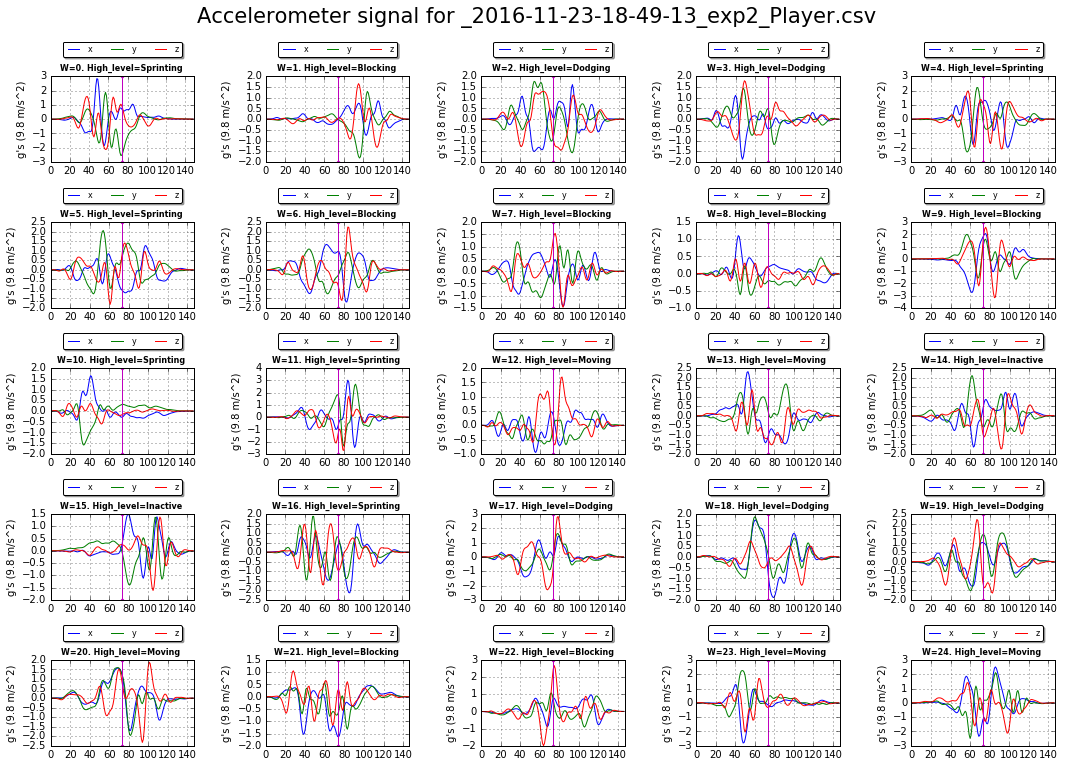

In [249]:
plotAcc(dataset[1])

#plt.plot(dataset[0]['x'][1])
#print len(d)
#mf.fft(dataset[-1][0]['x'])

In [250]:
import hmmc_scaled_concat as hmmc

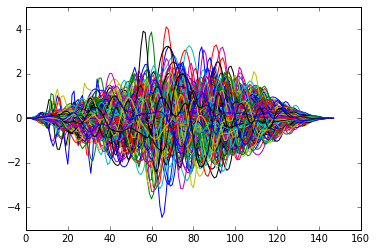

it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 10
it: 11
it: 12
it: 13
it: 14
it: 15
it: 16
it: 17
it: 18
it: 19
it: 20
it: 21
it: 22
it: 23
it: 24


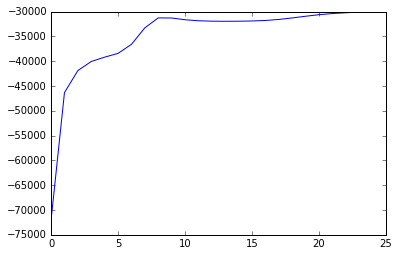

LL for fitted params: -29921.8890221


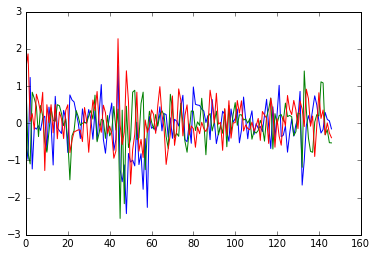

In [261]:
hmm = hmmc.HMM(5, 5)

nfile = 4
target = 'Inactive'
test_data = []
for nfile in range(len(dataset)):
    for d in range(len(dataset[nfile])):
        if dataset[nfile]['l'][d][0] == target:
            test_data.append(np.array([[x, y,z] for x,y,z in zip(dataset[nfile]['x'][d],
                                                                 dataset[nfile]['y'][d],
                                                                 dataset[nfile]['z'][d])]))

for signal in test_data:
    for d in xrange(signal.shape[1]):
        plt.plot(signal[:,d])
plt.show()
hmm.fit(test_data, verbose=False)
L = hmm.log_likelihood_multi(test_data).sum()
print "LL for fitted params:", L

est_samples = hmm.generate_samples(1, test_data[0].shape[0])
for signal in est_samples:
    for d in xrange(est_samples[0].shape[1]):
        plt.plot(signal[:,d])
plt.show()

## Framing

In [ ]:
dic = {'x'   :[x[0] for x in datasetX],
       'y'   :[y[0] for y in datasetY],
       'z'   :[z[0] for z in datasetZ],
       'file':[f[1] for f in datasetX],} 
df = pd.DataFrame(dic, columns=['x','y','z','file'])

#### Plotting

In [ ]:
plt.plot(df.loc[0]['x'], label='x')
plt.plot(df.loc[0]['y'], label='y')
plt.plot(df.loc[0]['z'], label='z')
plt.legend(loc='best', frameon=False)
plt.show()

## Windows details

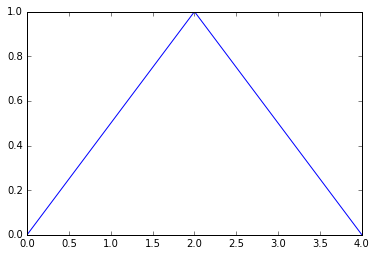

In [60]:
segment_len = 5   # WINDOWS SIZE
slide_len = 4      # WINDOWS OVERLAP

### windowing function
window_rads = np.linspace(0, np.pi, 5)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()

In [ ]:

for i in range(df.shape[0]):
    f_number = i

    x_segments = []
    x_energies = []
    y_segments = []
    y_energies = []
    z_segments = []
    z_energies = []

    x_means = []
    y_means = []
    z_means = []

    correlationxy = []
    correlationxz = []
    correlationzy = []
    #for i in range(df.shape[0]):
    the_data_x = df['x'].tolist()[f_number]
    the_data_y = df['y'].tolist()[f_number]
    the_data_z = df['z'].tolist()[f_number]
    for start_pos in range(0, len(the_data_x), slide_len):
        end_pos = start_pos + segment_len
        # make a copy so changes to 'segments' doesn't modify the original data
        x_segment = np.copy(the_data_x[start_pos:end_pos])
        y_segment = np.copy(the_data_y[start_pos:end_pos])
        z_segment = np.copy(the_data_z[start_pos:end_pos])
        # if we're at the end and we've got a truncated segment, drop it
        if len(x_segment) != segment_len:
            continue

        ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
        x_segment = x_segment * window
        y_segment = y_segment * window
        z_segment = z_segment * window

        x_segments.append(x_segment)     
        x_energies.append(mf.fft_energy(x_segment))
        x_means.append(mf.mean(x_segment))
        y_segments.append(y_segment)     ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
        y_energies.append(mf.fft_energy(y_segment))
        y_means.append(mf.mean(y_segment))
        z_segments.append(z_segment)     ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
        z_energies.append(mf.fft_energy(z_segment))
        z_means.append(mf.mean(z_segment))

        correlationxy.append(mf.correlation(x_segment,y_segment))
        correlationzy.append(mf.correlation(z_segment,y_segment))
        correlationxz.append(mf.correlation(x_segment,z_segment))

    #print (len(the_data)/4) -8
    a = range(0,len(the_data_x),4)
    x = a[:len(x_energies)]
    y = a[:len(y_energies)]
    z = a[:len(z_energies)]

    plt.figure(figsize=(19,4))
    #plt.plot(the_data_x, label='x')
    plt.plot(x,x_energies, label='x_energy')
    #plt.plot(the_data_y, label='y')
    plt.plot(y,y_energies, label='y_energy')
    #plt.plot(the_data_z, label='z')
    plt.plot(z,z_energies, label='z_energy')
    #combined = [i+j+k for i,j,k in zip(x_energies,y_energies,z_energies)]
    #plt.plot(z,combined, label='combined')
    plt.legend(loc='lower right', frameon=False, fontsize=14)
    plt.xlabel('samples')
    plt.ylabel('energy')
    plt.xlim(0,plt.xlim()[1])
    plt.legend(loc='best', frameon=False, fontsize=14)

    plt.draw()

    print("Produced %d waveform segments" % len(x_segments))

## Visualizing

In [ ]:
#print (len(the_data)/4) -8
a = range(0,len(the_data_x),4)
x = a[:len(x_energies)]
y = a[:len(y_energies)]
z = a[:len(z_energies)]

In [ ]:
plt.figure(figsize=(19,4))
plt.plot(the_data_x, label='x')
#plt.plot(x,x_energies, label='x_energy')
#plt.plot(the_data_y, label='y')
#plt.plot(y,y_energies, label='y_energy')
#plt.plot(the_data_z, label='z')
#plt.plot(z,z_energies, label='z_energy')
#combined = [i+j+k for i,j,k in zip(x_energies,y_energies,z_energies)]
#plt.plot(z,combined, label='combined')
plt.legend(loc='lower right', frameon=False, fontsize=14)
plt.xlabel('samples')
plt.ylabel('energy')
plt.xlim(0,plt.xlim()[1])
plt.legend(loc='best', frameon=False, fontsize=14)

plt.show()